In [1]:
test_mode = False

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import hopsworks
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import joblib
import pickle
import utils
from utils import fng_labels_to_numbers_map

/opt/anaconda3/envs/crypto-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Connect to hopsworks

In [3]:
load_dotenv()
os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login()

fs = project.get_feature_store() 

2025-01-04 19:04:17,187 INFO: Initializing external client
2025-01-04 19:04:17,187 INFO: Base URL: https://c.app.hopsworks.ai:443

Multiple projects found. 

	 (1) kth_lab1_2024
	 (2) ID2223_AirQuality_Lab1
2025-01-04 19:04:21,327 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164448


### Read data from hopsworks and merge them into a feature table

In [4]:
# ****************** Solana data ******************

solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=1
)

# Step 3: Read the data from the feature group
solana_df = solana_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
# solana_df['open_diff'] = solana_df['open'].diff().fillna(0)
solana_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


,timestamp,open,high,low,close,volume,volume_buy,volume_sell
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646
...,...,...,...,...,...,...,...,...
1290,1735344000,183.81,186.47,183.57,185.64,30635.592390,19058.783527,11576.808863
1291,1735430400,195.15,197.19,188.26,189.60,120179.830193,45590.791614,74589.038579
1292,1735516800,189.60,196.10,185.58,191.06,186701.859563,80979.111912,105722.747651
1293,1735603200,191.06,198.73,187.76,188.95,169485.435743,98813.418835,70672.016908


In [5]:
# ****************** Bitcoin Data ******************
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=1
)

# Step 3: Read the data from the feature group
bitcoin_df = bitcoin_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
# bitcoin_df['open_diff'] = bitcoin_df['open'].diff()
bitcoin_df = bitcoin_df[["timestamp","open"]]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


In [6]:
# ****************** Fear and Greed Index Data ******************

#fs = project.get_feature_store(name='kth_lab1_2024_featurestore')
fs = project.get_feature_store()
fng_feature_group = fs.get_feature_group('f_n_g_index', version=1)
fng_df = fng_feature_group.read()
fng_df['timestamp'] = fng_df['timestamp'].astype(float)
fng_df['fng_classification'] = fng_df['fng_classification'].map(fng_labels_to_numbers_map)

fng_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,fng_value,fng_classification,timestamp
0,74,3,1.718410e+09
1,77,4,1.710720e+09
2,43,1,1.550189e+09
3,68,3,1.721952e+09
4,30,1,1.659571e+09
...,...,...,...
2521,50,2,1.589760e+09
2522,79,4,1.707782e+09
2523,27,1,1.645747e+09
2524,28,1,1.542586e+09


In [7]:

all_data = pd.merge(solana_df, bitcoin_df, how='inner', on="timestamp",suffixes=('_solana', '_bitcoin'))  
all_data = pd.merge(all_data, fng_df, how='inner', on="timestamp")
all_data.head()


,timestamp,open_solana,high,low,close,volume,volume_buy,volume_sell,open_bitcoin,fng_value,fng_classification
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166,38337.1,26,1
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887,38078.2,25,0
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583,35824.0,23,0
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001,35490.5,21,0
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646,35595.0,23,0


### Data Preprocessing

In [8]:
# All data object will be used as features and thus we dont need timestamp
if "timestamp" in all_data.columns:
    all_data = all_data.drop(columns=['timestamp'])

target_column = 'open_solana'
all_data = utils.move_target_at_the_end(all_data, target_column)
all_data_values = all_data.values

all_data.head()

,high,low,close,volume,volume_buy,volume_sell,open_bitcoin,fng_value,fng_classification,open_solana
0,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166,38337.1,26,1,40.23
1,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887,38078.2,25,0,39.13
2,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583,35824.0,23,0,36.62
3,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001,35490.5,21,0,35.45
4,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646,35595.0,23,0,35.28


In [9]:
time_steps = 30
num_predictions = 10
X, y = utils.create_sequences(all_data_values, time_steps=time_steps, num_predictions=num_predictions)
# y_percentage_change = create_featured_label(all_data_values, time_steps=time_steps, num_predictions=num_predictions)
X.shape, y.shape

((1254, 30, 10), (1254, 10))

### Separate dataset into train validation and test set 

In [10]:

(X_train, X_val, X_test, y_train, y_val, y_test ) = utils.train_val_test_split(X, y)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
print(f"Labels1_train shape: {y_train.shape}, Labels1 val shape: {y_val.shape}, Labels1_test shape: {y_test.shape}")


X_train shape: (702, 30, 10), X_val shape: (301, 30, 10), X_test shape: (251, 30, 10)
Labels1_train shape: (702, 10), Labels1 val shape: (301, 10), Labels1_test shape: (251, 10)


### Normalize data in order to be used with the model

In [11]:
scaler_features = MinMaxScaler(feature_range=(0, 1))

data_reshaped = X_train.reshape(-1, X_train.shape[2])  # Shape: (12680, 18)

data_scaled = scaler_features.fit_transform(data_reshaped)

X_train = data_scaled.reshape(X_train.shape)

# ************************************************

data_reshaped = X_val.reshape(-1, X_val.shape[2])  

data_scaled = scaler_features.transform(data_reshaped)

X_val = data_scaled.reshape(X_val.shape)

# *************************************************
data_reshaped = X_test.reshape(-1, X_test.shape[2]) 


data_scaled = scaler_features.transform(data_reshaped)

X_test = data_scaled.reshape(X_test.shape)



In [12]:
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_labels.fit(y_train)

y_train = scaler_labels.transform(y_train)
y_val = scaler_labels.transform(y_val)
y_test = scaler_labels.transform(y_test)

### Train LSTM Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

In [70]:

model = Sequential()
model.add(InputLayer((time_steps, X.shape[2])))
model.add(LSTM(12, return_sequences=False))  # L2 regularization
model.add(Dense(y.shape[1], activation='relu'))       # L2 regularization
model.add(Dense(y.shape[1], activation='linear'))        
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 12)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,344 (5.25 KB)

 Trainable params: 1,344 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
cp2 = ModelCheckpoint('solana_price_model_10d/best_model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), R2Score()])

In [75]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape


((702, 30, 10), (702, 10), (301, 30, 10), (301, 10))

In [76]:
# Train model with train dataset
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[cp2])

Epoch 1/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - r2_score: 0.9596 - val_loss: 0.0071 - val_mean_squared_error: 0.0104 - val_r2_score: 0.8464
Epoch 2/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - r2_score: 0.9634 - val_loss: 0.0070 - val_mean_squared_error: 0.0103 - val_r2_score: 0.8483
Epoch 3/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - r2_score: 0.9624 - val_loss: 0.0069 - val_mean_squared_error: 0.0101 - val_r2_score: 0.8512
Epoch 4/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - r2_score: 0.9619 - val_loss: 0.0070 - val_mean_squared_error: 0.0102 - val_r2_score: 0.8502
Epoch 5/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - r2_score: 0.9603 - val_loss: 0.0069 - val_mean_squared_error: 0.0101 - val_r2_score: 0.8512
Epoch 6/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

In [18]:
X_train.shape

(702, 30, 10)

In [19]:
# train_predictions = model.predict(X_train).flatten()
# y_train_flattened = y_train.flatten()
# train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_flattened})
# train_results

In [20]:
# from tensorflow.keras.models import load_model

# model = load_model('model2/best_model.keras')


#### Train with validation set


In [77]:
model.fit(X_val, y_val, validation_data=(X_train, y_train), epochs=10, callbacks=[cp2])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0069 - r2_score: 0.8508 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_r2_score: 0.9622
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - r2_score: 0.9054 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_r2_score: 0.9428
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - r2_score: 0.9579 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_r2_score: 0.9399
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0022 - r2_score: 0.9508 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_r2_score: 0.9379
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - r2_score: 0.9628 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_r2_score: 0.9371
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

### Evaluate Model

In [78]:
def evaluation_metrics(y_predictions, y_actuals):
    y_predictions_flattened = y_predictions.flatten()
    y_actuals_flattened = y_actuals.flatten()

    mse = mean_squared_error(y_actuals_flattened, y_predictions_flattened)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_actuals_flattened, y_predictions_flattened)

    res_dict = { 
            "mse": str(mse),
            "r_squared": str(r_squared),
        }
    
    return res_dict

In [79]:
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Metrics calculated on normalized data
res_dict_val = evaluation_metrics(val_predictions, y_val)

print("**********************")
print(f"Val Mean Squared Error (MSE): {res_dict_val['mse']}")
print(F"R-squared on validation set: {res_dict_val['r_squared']}")

res_dict_test = evaluation_metrics(test_predictions, y_test)

print("**********************")
print(f"Test Mean Squared Error (MSE): {res_dict_test['mse']}")
print(F"R-squared on test set: {res_dict_test['r_squared']}")


# Metrics calculated on unnormalized data

y_val_unscaled = scaler_labels.inverse_transform(y_val)
val_predictions_unscaled =  scaler_labels.inverse_transform(val_predictions)
res_dict_val_unscaled = evaluation_metrics(val_predictions_unscaled, y_val_unscaled)
print("**********************")
print(f"Val Mean Squared Error (MSE) unormalized: {res_dict_val_unscaled['mse']}")
print(F"R-squared on validation set unormalized: {res_dict_val_unscaled['r_squared']}")

y_test_unscaled = scaler_labels.inverse_transform(y_test)
test_predictions_unscaled =  scaler_labels.inverse_transform(test_predictions)
res_dict_test_unscaled = evaluation_metrics(test_predictions_unscaled, y_test_unscaled)
print("**********************")
print(f"Test MSE unormalized: {res_dict_test_unscaled['mse']}")
print(F"R-squared on test set unormalized: {res_dict_test_unscaled['r_squared']}")




10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
**********************
Val Mean Squared Error (MSE): 0.0014631831018081121
R-squared on validation set: 0.9684435332393603
**********************
Test Mean Squared Error (MSE): 0.006129461304592241
R-squared on test set: 0.6369056337332566
**********************
Val Mean Squared Error (MSE) unormalized: 90.74796085288314
R-squared on validation set unormalized: 0.9684435344880169
**********************
Test MSE unormalized: 380.154854703858
R-squared on test set unormalized: 0.6369056187554978


In [80]:
def plot_predictions(y_predicted_sample, y_actual_sample, num_predictions):
  df = pd.DataFrame(data={'Predictions': y_predicted_sample, 'Actuals':y_actual_sample})
  plt.plot(df['Predictions'][0:num_predictions], label='Predictions')
  plt.plot(df['Actuals'][0:num_predictions], label='Actuals')
  plt.legend()

  plt.show()

  return 

def predictions_table(y_predicted, y_actual, num_predictions):
  combined_array = np.column_stack((y_predicted, y_actual))
  
  results_price = pd.DataFrame(combined_array[:num_predictions], columns=['y_predicted_price','y_actual_price'])
  display(results_price)



### Plot some predictions vs actuals

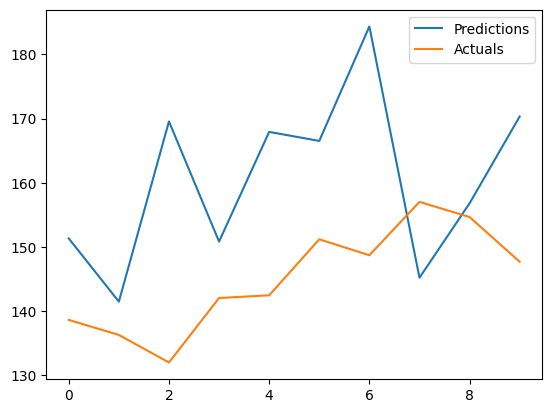

,y_predicted_price,y_actual_price
0,151.337128,138.65
1,141.492462,136.31
2,169.557938,132.02
3,150.846786,142.06
4,167.928543,142.48
5,166.519104,151.20
6,184.342453,148.72
7,145.219147,157.03
8,156.807236,154.67
9,170.325470,147.71


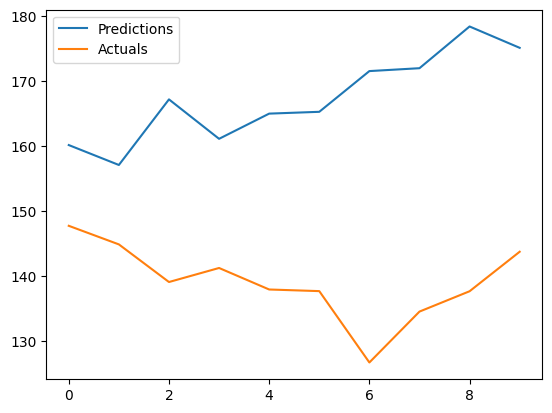

,y_predicted_price,y_actual_price
0,160.135071,147.71
1,157.069229,144.85
2,167.162201,139.06
3,161.095428,141.22
4,164.972427,137.91
5,165.250275,137.66
6,171.517136,126.68
7,171.960892,134.51
8,178.381332,137.64
9,175.096191,143.72


In [81]:
test_predictions_unscaled = scaler_labels.inverse_transform(test_predictions)
y_test_unscaled = scaler_labels.inverse_transform(y_test)
for i in [1, 10]:  
    plot_predictions(test_predictions_unscaled[i], y_test_unscaled[i], num_predictions)
    predictions_table(test_predictions_unscaled[i], y_test_unscaled[i], num_predictions)

### Train model also on test set before deploying

In [82]:
model.fit(X_test, y_test, validation_data=(X_train, y_train), epochs=10, callbacks=[cp2])

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - r2_score: 0.6507 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_r2_score: 0.9325
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - r2_score: 0.6070 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_r2_score: 0.9290
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0052 - r2_score: 0.6786 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_r2_score: 0.9355
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - r2_score: 0.6620 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_r2_score: 0.9325
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - r2_score: 0.7010 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_r2_score: 0.9291
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 -

## Save model on registry

In [84]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [85]:
model_dir = "solana_price_model_10d/"
scalers_dir = "solana_price_10d_scalers/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
if not os.path.exists(scalers_dir):
    os.mkdir(scalers_dir)

In [87]:
mr = project.get_model_registry()


# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()


sample_indices = np.random.choice(X_test.shape[0], size=17, replace=False)
sample_test_values = X_test[sample_indices]


solana_model = mr.python.create_model(
    name="solana_price_daily_model_10d", 
    metrics= res_dict_test,
    model_schema=model_schema,
    input_example=sample_test_values, 
    version=4,
    description="Solana daily price predictor. Predicts 10 days using solana lagged 30 timesteps, bitcoin lagged price (10) and fear greed index",
)
if not test_mode:
    model.save(model_dir + "best_model.keras")
    joblib.dump(scaler_features, 'scaler_features.pkl')
    joblib.dump(scaler_labels, 'scaler_labels.pkl')
    solana_model.save(model_dir)

Uploading: 100.000%|██████████| 45638/45638 elapsed<00:02 remaining<00:005,  1.06s/it]
Uploading: 100.000%|██████████| 96584/96584 elapsed<00:02 remaining<00:0008,  2.17s/it]
Uploading: 100.000%|██████████| 219/219 elapsed<00:02 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1164448/models/solana_price_daily_model_10d/4


In [88]:

# min_max_scaler = fs.create_transformation_function(
#         transformation_function="min_max_scaler",
#         description="Scales features to a range between 0 and 1",
#         version=1
#     )

# min_max_scaler.save()